In [106]:
import xarray as xr 
import matplotlib.pyplot as plt 
import glob 
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
#import collections
import matplotlib.ticker as mticker
from matplotlib import ticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
import scipy as sp
from scipy.stats import linregress
import sklearn.linear_model as LR
import scipy.stats as stats

import pandas as pd
import geocat.comp as gcomp
import xesmf as xe

In [2]:
SEAS = 'ANN'

In [3]:
seasons = {"ANN": np.arange(1,13,1),
            "DJF": [12, 1, 2],
            "JJA": [6, 7, 8],
            "MAM": [3, 4, 5],
            "SON": [9, 10, 11]
            }
DTDT = pd.date_range(start='1980-01-01',end='1980-12-01',freq='1MS')
# Create a DataFrame to hold the date range
df = pd.DataFrame({'date': DTDT})

# Extract the number of days in each month
df['days_in_month'] = df['date'].dt.days_in_month
df['month'] = df['date'].dt.month
df

,date,days_in_month,month
0,1980-01-01,31,1
1,1980-02-01,29,2
2,1980-03-01,31,3
3,1980-04-01,30,4
4,1980-05-01,31,5
5,1980-06-01,30,6
6,1980-07-01,31,7
7,1980-08-01,31,8
8,1980-09-01,30,9
9,1980-10-01,31,10


In [121]:
def vert_int(DS_u, DS_tbot, DS_z, var_name_u, var_name_tbot, var_name_z, dolevs):
    dd = DS_u[var_name_u]
    ddps = DS_u['PS']
    ddz = DS_z[var_name_z].sel(lev=1000, method='nearest')* 9.81
    ddtbot = DS_tbot[var_name_tbot] 
    hyam = DS_u['hyam']
    hybm = DS_u['hybm']
    INTER = gcomp.interpolation.interp_hybrid_to_pressure(data=dd, ps=ddps, hyam=hyam, hybm=hybm, new_levels=dolevs*100, extrapolate=True, variable='other', t_bot=ddtbot, phi_sfc=ddz)
    INTER = INTER.rename({'plev':'lev'})
    INTER['lev'] = dolevs
    print('...loading interpolation..')
    INTER.load()
    INTER.to_dataset(name = var_name_u)
    return INTER


def seas_mean(DS, df, season):
    DSdo = DS.sel(time=DS.time.isin(seasons[season]))

    if np.isin(season,['DJF','MAM','SON','JJA']):
        m1w=df[df['month']==DSdo.time[0].values]['days_in_month'].values[0]
        m2w=df[df['month']==DSdo.time[1].values]['days_in_month'].values[0]
        m3w=df[df['month']==DSdo.time[2].values]['days_in_month'].values[0]
        weights = np.array([m1w,m2w,m3w])
    if season =='ANN':
        m1w=df[df['month']==DSdo.time[0].values]['days_in_month'].values[0]
        m2w=df[df['month']==DSdo.time[1].values]['days_in_month'].values[0]
        m3w=df[df['month']==DSdo.time[2].values]['days_in_month'].values[0]
        m4w=df[df['month']==DSdo.time[3].values]['days_in_month'].values[0]
        m5w=df[df['month']==DSdo.time[4].values]['days_in_month'].values[0]
        m6w=df[df['month']==DSdo.time[5].values]['days_in_month'].values[0]
        m7w=df[df['month']==DSdo.time[6].values]['days_in_month'].values[0]
        m8w=df[df['month']==DSdo.time[7].values]['days_in_month'].values[0]
        m9w=df[df['month']==DSdo.time[8].values]['days_in_month'].values[0]
        m10w=df[df['month']==DSdo.time[9].values]['days_in_month'].values[0]
        m11w=df[df['month']==DSdo.time[10].values]['days_in_month'].values[0]
        m12w=df[df['month']==DSdo.time[11].values]['days_in_month'].values[0]
        weights = np.array([m1w,m2w,m3w,m4w,m5w,m6w,m7w,m8w,m9w,m10w,m11w,m12w])
        
    weights = weights/weights.sum()
    ds_weighted = (DSdo*np.expand_dims(np.expand_dims(weights,1),1))
    DSseas = ds_weighted.sum(dim='time')

    return DSseas.load()

def wgt_rmse(fld1, fld2, wgt):
    """Calculate the area-weighted RMSE.

    Parameters
    ----------
    fld1, fld2 : array-like
        2-dimensional spatial fields with the same shape.
        They can be xarray DataArray or numpy arrays.
    wgt : array-like
        the weight vector, expected to be 1-dimensional,
        matching length of one dimension of the data.

    Returns
    -------
    float
        root mean squared error

    Notes:
    ```rmse = sqrt( mean( (fld1 - fld2)**2 ) )```
    """
    assert len(fld1.shape) == 2,     "Input fields must have exactly two dimensions."
    assert fld1.shape == fld2.shape, "Input fields must have the same array shape."
    # in case these fields are in dask arrays, compute them now.
    if hasattr(fld1, "compute"):
        fld1 = fld1.compute()
    if hasattr(fld2, "compute"):
        fld2 = fld2.compute()
    if isinstance(fld1, xr.DataArray) and isinstance(fld2, xr.DataArray):
        return (np.sqrt(((fld1 - fld2)**2).weighted(wgt).mean())).values.item()
    else:
        check = [len(wgt) == s for s in fld1.shape]
        if ~np.any(check):
            raise IOError(f"Sorry, weight array has shape {wgt.shape} which is not compatible with data of shape {fld1.shape}")
        check = [len(wgt) != s for s in fld1.shape]
        dimsize = fld1.shape[np.argwhere(check).item()]  # want to get the dimension length for the dim that does not match the size of wgt
        warray = np.tile(wgt, (dimsize, 1)).transpose()   # May need more logic to ensure shape is correct.
        warray = warray / np.sum(warray) # normalize
        wmse = np.sum(warray * (fld1 - fld2)**2)
        return np.sqrt( wmse ).item()

In [122]:
lvlv=500
dolevs = np.array([100., 150., 200., 250., 300., 400., 500., 600., 700., 850., 925., 1000.])

DSsuper5 = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/CAM5_Betzy1/climo/CAM5_Betzy1_T_climo.nc')
DSsuper5z = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/CAM5_Betzy1/climo/CAM5_Betzy1_Z3_climo.nc')
DSsuper5 = vert_int(DSsuper5, DSsuper5, DSsuper5z, 'T', 'T', 'Z3', dolevs).sel(lev=lvlv)
DSsuper5_season = seas_mean(DSsuper5,df,SEAS)

DSmme = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/MME_Regular/climo/MME_Regular_T_climo.nc')
DSmmez = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/MME_Regular/climo/MME_Regular_Z3_climo.nc')
DSmme = vert_int(DSmme, DSmme, DSmmez, 'T', 'T', 'Z3', dolevs).sel(lev=lvlv)
DSMME_Season = seas_mean(DSmme,df,SEAS)

DSc5 = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/FHIST5_f09_g16_v2/climo/FHIST5_f09_g16_v2_T_climo.nc')
DSc5z = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/FHIST5_f09_g16_v2/climo/FHIST5_f09_g16_v2_Z3_climo.nc')
DSc5 = vert_int(DSc5, DSc5, DSc5z, 'T', 'T', 'Z3', dolevs).sel(lev=lvlv)
DSCAM5_Season = seas_mean(DSc5,df,SEAS)

DSsuper6 = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/CAM6_Betzy1/climo/CAM6_Betzy1_T_climo.nc')
DSsuper6z = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/CAM6_Betzy1/climo/CAM6_Betzy1_Z3_climo.nc')
DSsuper6 = vert_int(DSsuper6, DSsuper6, DSsuper6z, 'T', 'T', 'Z3', dolevs).sel(lev=lvlv)
DSsuper6_season = seas_mean(DSsuper6,df,SEAS)

DSc6 = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/FHIST_f09_g16/climo/FHIST_f09_g16_T_climo.nc')
DSc6z = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/FHIST_f09_g16/climo/FHIST_f09_g16_Z3_climo.nc')
DSc6 = vert_int(DSc6, DSc6, DSc6z, 'T', 'T', 'Z3', dolevs).sel(lev=lvlv)
DSCAM6_season = seas_mean(DSc6,df,SEAS)

DSmmer = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/MME_Combined/climo/MME_Combined_T_climo.nc')
DSmmerz = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/MME_Combined/climo/MME_Combined_Z3_climo.nc')
DSmmer = vert_int(DSmmer, DSmmer, DSmmerz, 'T', 'T', 'Z3', dolevs).sel(lev=lvlv)
DSMMEr_season = seas_mean(DSmmer,df,SEAS)

DSobs = xr.open_dataset('/glade/work/wchapman/ADF_obs_Mar2024/T_ERA5_monthly_climo_197901-202112.nc').sel(lev=lvlv)['T']
print('...taking obs mean....')
DSobs_season = seas_mean(DSobs,df,SEAS)

grid_out = xr.Dataset(
        {"lat": (["lat"], DSmmer.lat.data)},
        {"lon": (["lon"], DSmmer.lon.data)}
    )
regridder = xe.Regridder(
                DSobs_season, grid_out, "bilinear", periodic=True,
                reuse_weights=False
            )

DSobs_season = regridder(DSobs_season)

...loading interpolation..


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/geocat/comp/interpolation.py:133: UserWarning: Interpolation point out of data bounds encountered
  return func_interpolate(new_levels, xcoords, data, axis=interp_axis)


...loading interpolation..


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/geocat/comp/interpolation.py:133: UserWarning: Interpolation point out of data bounds encountered
  return func_interpolate(new_levels, xcoords, data, axis=interp_axis)


...loading interpolation..


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/geocat/comp/interpolation.py:133: UserWarning: Interpolation point out of data bounds encountered
  return func_interpolate(new_levels, xcoords, data, axis=interp_axis)


...loading interpolation..


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/geocat/comp/interpolation.py:133: UserWarning: Interpolation point out of data bounds encountered
  return func_interpolate(new_levels, xcoords, data, axis=interp_axis)


...loading interpolation..


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/geocat/comp/interpolation.py:133: UserWarning: Interpolation point out of data bounds encountered
  return func_interpolate(new_levels, xcoords, data, axis=interp_axis)


...loading interpolation..


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/geocat/comp/interpolation.py:133: UserWarning: Interpolation point out of data bounds encountered
  return func_interpolate(new_levels, xcoords, data, axis=interp_axis)


...taking obs mean....


## Difference in Climo

In [123]:
clevs = np.arange(-1.5, 1.6, .1)
bluey = mpl.cm.get_cmap('RdGy_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
cmapzzz = ListedColormap(newcolors)

/glade/derecho/scratch/wchapman/tmp/ipykernel_26457/744812097.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluey = mpl.cm.get_cmap('RdGy_r', len(clevs))


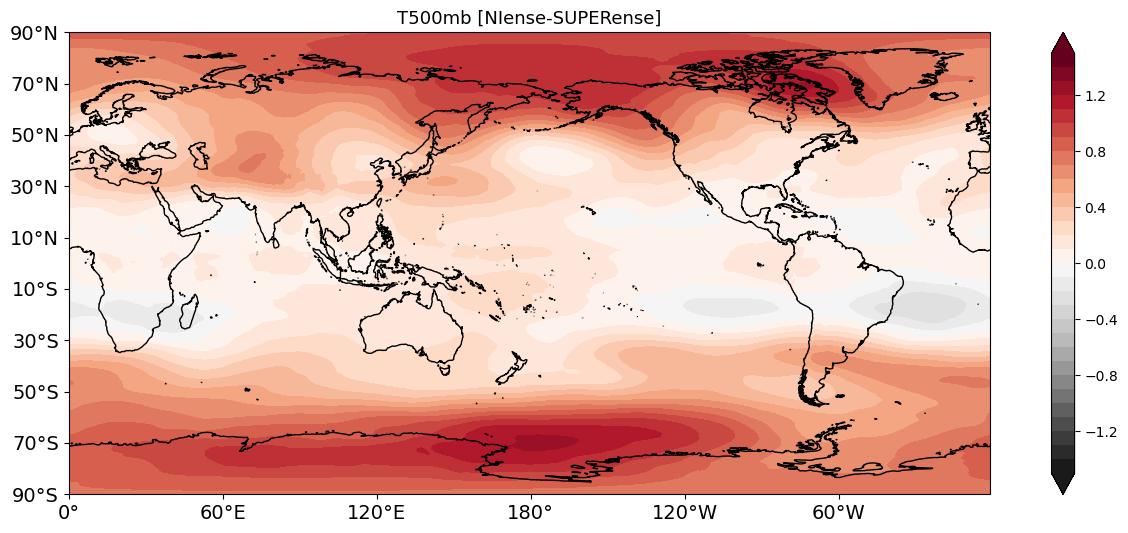

In [125]:
plotter = DSMME_Season-DSMMEr_season

proj = ccrs.PlateCarree(central_longitude=180)
fig, ax1 = plt.subplots(1, 1, figsize=(16,6), subplot_kw={'projection': proj}, sharey=True)

lons = DSCAM6_season['lon']
lats = DSCAM6_season['lat']

ax1.coastlines('50m')
f = ax1.contourf(lons-180, lats, plotter, levels = clevs ,cmap = cmapzzz, extend='both', transform=proj)
ax1.set_xticks(np.arange(-180,180,60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax1.xaxis.set_major_formatter(lon_formatter)

ax1.set_yticks(np.arange(-90,100,20))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_title(f'T{lvlv}mb [NIense-SUPERense]', fontsize=13)
ax1.tick_params(labelsize=14)
plt.colorbar(f)
plt.savefig(f'./{SEAS}_T{lvlv}_NIense_vs_Super6.png',bbox_inches='tight',dpi=400)
plt.show()


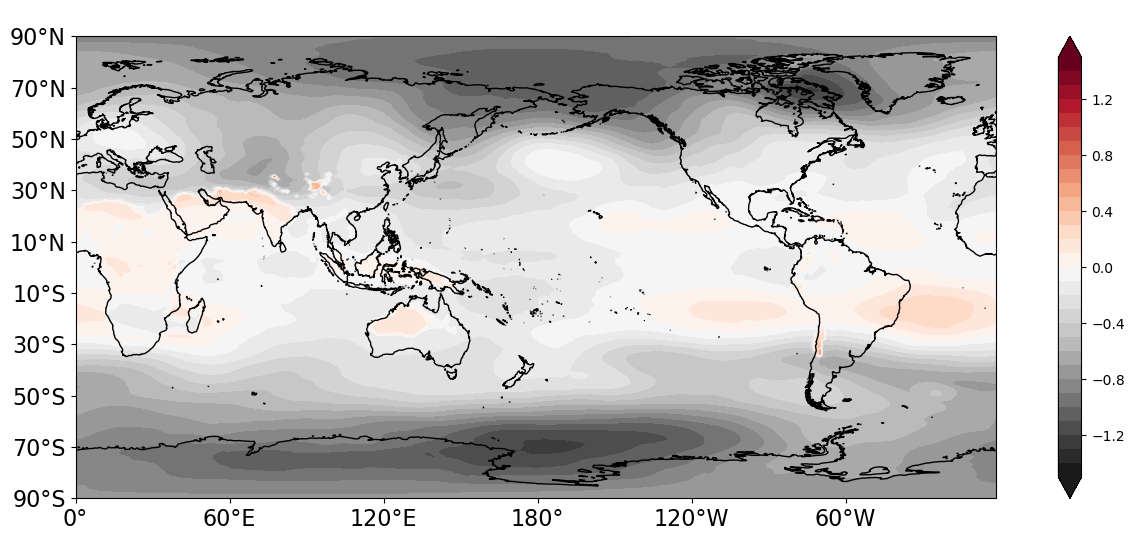

In [126]:
plotter1 = np.abs(DSMME_Season-DSobs_season)
plotter2 = np.abs(DSMMEr_season-DSobs_season)

proj = ccrs.PlateCarree(central_longitude=180)
fig, ax1 = plt.subplots(1, 1, figsize=(16,6), subplot_kw={'projection': proj}, sharey=True)

lons = DSCAM6_season['lon']
lats = DSCAM6_season['lat']

ax1.coastlines('50m')
f = ax1.contourf(lons-180, lats, plotter1 - plotter2, levels = clevs ,cmap = cmapzzz, extend='both', transform=proj)
ax1.set_xticks(np.arange(-180,180,60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax1.xaxis.set_major_formatter(lon_formatter)

ax1.set_yticks(np.arange(-90,100,20))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_title(' ', fontsize=16)
ax1.tick_params(labelsize=16)
plt.colorbar(f)
plt.savefig(f'./{SEAS}_T850_NIense-Super6_BiasDiff.png',bbox_inches='tight',dpi=400)
plt.show()

/glade/derecho/scratch/wchapman/tmp/ipykernel_26457/2263287648.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluey = mpl.cm.get_cmap('PuOr_r', len(clevs))
/glade/derecho/scratch/wchapman/tmp/ipykernel_26457/2263287648.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluey_obs = mpl.cm.get_cmap('RdYlBu_r', len(clevs_obs))


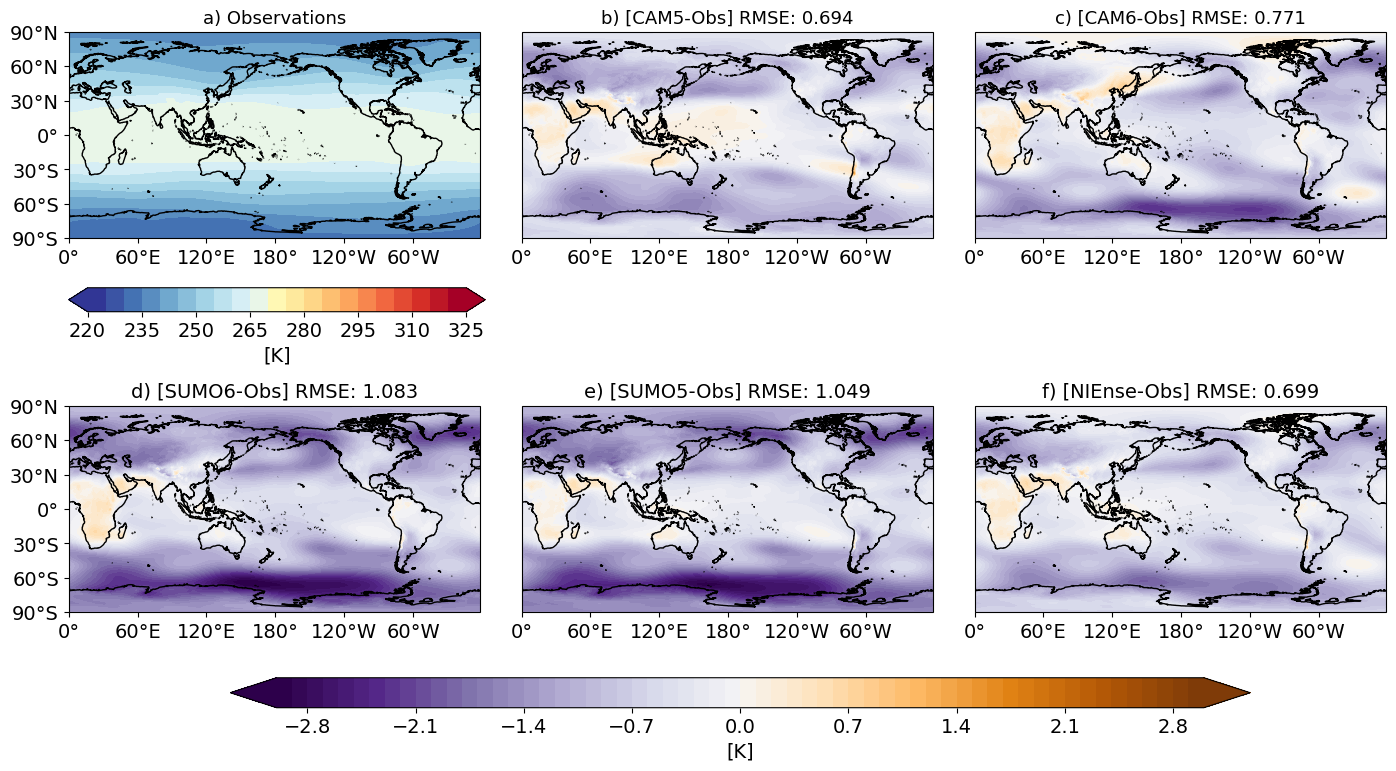

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.gridspec as gridspec

# Assuming DSobs_season, DSCAM6_season, DSsuper5_season, DSMME_Season are already defined datasets

clevs = np.arange(-3, 3.1, .1)
bluey = mpl.cm.get_cmap('PuOr_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
cmapzzz = ListedColormap(newcolors)

clevs_obs = np.arange(220, 330, 5)
bluey_obs = mpl.cm.get_cmap('RdYlBu_r', len(clevs_obs))
newcolors_obs = bluey_obs(np.linspace(0, 1, len(clevs_obs)))
cmapzzz_obs = ListedColormap(newcolors_obs)
proj = ccrs.PlateCarree(central_longitude=180)

fig = plt.figure(figsize=(17, 12))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 2], width_ratios=[1, 1, 1], wspace=0.1, hspace=-.32)

# Top left panel for new data
ax_top_left = fig.add_subplot(gs[0, 0], projection=proj)
plotter_obs = DSobs_season 

ax_top_left.coastlines('50m')
f_obs = ax_top_left.contourf(lons - 180, lats, plotter_obs, levels=clevs_obs, cmap=cmapzzz_obs, extend='both', transform=proj)
ax_top_left.set_xticks(np.arange(-180, 180, 60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax_top_left.xaxis.set_major_formatter(lon_formatter)
ax_top_left.set_yticks(np.arange(-90, 100, 30))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax_top_left.yaxis.set_major_formatter(lat_formatter)
ax_top_left.set_title('a) Observations', fontsize=13)
ax_top_left.tick_params(labelsize=14)

# Top middle panel for observations
ax_top_middle = fig.add_subplot(gs[0, 1], projection=proj)
plotter = DSCAM5_Season  - DSobs_season 
d_rmse = wgt_rmse(DSCAM5_Season , DSobs_season , wgt)  # correct weighted RMSE for (lat,lon) fields.
frmse = np.round(d_rmse, 3)

ax_top_middle.coastlines('50m')
f_diff = ax_top_middle.contourf(lons - 180, lats, plotter, levels=clevs, cmap=cmapzzz, extend='both', transform=proj)
ax_top_middle.set_xticks(np.arange(-180, 180, 60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax_top_middle.xaxis.set_major_formatter(lon_formatter)
ax_top_middle.set_yticks(np.arange(-90, 100, 30))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax_top_middle.yaxis.set_major_formatter(lat_formatter)
ax_top_middle.set_title(f'b) [CAM5-Obs] RMSE: {frmse}', fontsize=13)
ax_top_middle.tick_params(labelsize=14)
ax_top_middle.set_yticks([])  # Hide y-axis ticks for other subplots


# Top middle panel for observations
ax_top_middle = fig.add_subplot(gs[0, 2], projection=proj)
plotter = DSCAM6_season  - DSobs_season 
d_rmse = wgt_rmse(DSCAM6_season , DSobs_season , wgt)  # correct weighted RMSE for (lat,lon) fields.
frmse = np.round(d_rmse, 3)

ax_top_middle.coastlines('50m')
f_diff = ax_top_middle.contourf(lons - 180, lats, plotter, levels=clevs, cmap=cmapzzz, extend='both', transform=proj)
ax_top_middle.set_xticks(np.arange(-180, 180, 60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax_top_middle.xaxis.set_major_formatter(lon_formatter)
ax_top_middle.set_yticks(np.arange(-90, 100, 30))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax_top_middle.yaxis.set_major_formatter(lat_formatter)
ax_top_middle.set_title(f'c) [CAM6-Obs] RMSE: {frmse}', fontsize=13)
ax_top_middle.tick_params(labelsize=14)
ax_top_middle.set_yticks([])  # Hide y-axis ticks for other subplots


# Bottom row panels for difference fields
axs = [fig.add_subplot(gs[1, i], projection=proj) for i in range(3)]
for i, ax in enumerate(axs):
    if i == 0:
        plotter = DSsuper6_season  - DSobs_season 
        d_rmse = wgt_rmse(DSsuper6_season , DSobs_season , wgt)  # correct weighted RMSE for (lat,lon) fields.
        frmse = np.round(d_rmse, 3)
        
    elif i == 1:
        plotter = DSsuper5_season  - DSobs_season 
        # plotter = DSMMEr_season  - DSobs_season 
        d_rmse = wgt_rmse(DSsuper5_season , DSobs_season , wgt)  # correct weighted RMSE for (lat,lon) fields.
        frmse = np.round(d_rmse, 3)
        
    elif i == 2:
        plotter = DSMME_Season  - DSobs_season 
        d_rmse = wgt_rmse(DSMME_Season , DSobs_season , wgt)  # correct weighted RMSE for (lat,lon) fields.
        frmse = np.round(d_rmse, 3)
    
    ax.coastlines('50m')
    f_diff = ax.contourf(lons - 180, lats, plotter, levels=clevs, cmap=cmapzzz, extend='both', transform=proj)
    ax.set_xticks(np.arange(-180, 180, 60))
    lon_formatter = LongitudeFormatter(number_format='.0f')
    ax.xaxis.set_major_formatter(lon_formatter)
    
    if i == 0:
        ax.set_yticks(np.arange(-90, 100, 30))
        lat_formatter = LatitudeFormatter(number_format='.0f')
        ax.yaxis.set_major_formatter(lat_formatter)
    else:
        ax.set_yticks([])  # Hide y-axis ticks for other subplots
    
    if i == 0:
        ax.set_title(f'd) [SUMO6-Obs] RMSE: {frmse}', fontsize=14)
    elif i == 1:
        ax.set_title(f'e) [SUMO5-Obs] RMSE: {frmse}', fontsize=14)
    elif i == 2:
        ax.set_title(f'f) [NIEnse-Obs] RMSE: {frmse}', fontsize=14)
    
    ax.tick_params(labelsize=14)

cbar_ax_diff = fig.add_axes([0.22, 0.25, 0.6, 0.025])  # [left, bottom, width, height] in figure coordinate
cbar_diff = fig.colorbar(f_diff, cax=cbar_ax_diff, orientation='horizontal')
cbar_diff.ax.tick_params(labelsize=14)
cbar_diff.set_label(label='[K]', fontsize=14)

cbar_ax_obs = fig.add_axes([0.125, 0.58, 0.245, 0.02])  # [left, bottom, width, height] in figure coordinate
cbar_obs = fig.colorbar(f_obs, cax=cbar_ax_obs, orientation='horizontal')
cbar_obs.ax.tick_params(labelsize=14)
cbar_obs.set_label(label='[K]', fontsize=14)

plt.savefig(f'./{SEAS}_Bias_T{lvlv}mb_NIense-Super56.png', bbox_inches='tight', dpi=400)
plt.show()


## Hi hi

/glade/derecho/scratch/wchapman/tmp/ipykernel_26457/563196860.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluey = mpl.cm.get_cmap('PuOr_r', len(clevs))
/glade/derecho/scratch/wchapman/tmp/ipykernel_26457/563196860.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluey_obs = mpl.cm.get_cmap('RdYlBu_r', len(clevs_obs))


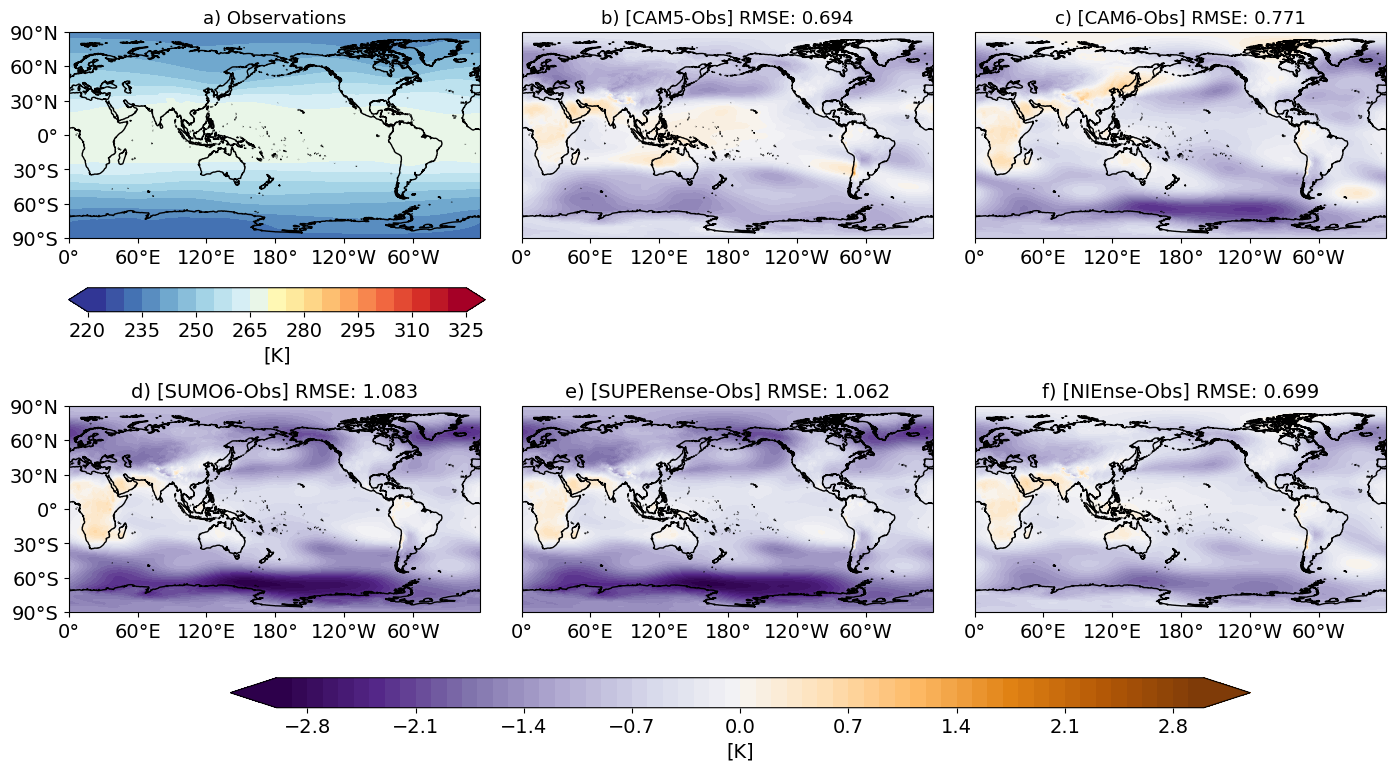

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.gridspec as gridspec

# Assuming DSobs_season, DSCAM6_season, DSsuper5_season, DSMME_Season are already defined datasets

clevs = np.arange(-3, 3.1, .1)
bluey = mpl.cm.get_cmap('PuOr_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
cmapzzz = ListedColormap(newcolors)

clevs_obs = np.arange(220, 330, 5)
bluey_obs = mpl.cm.get_cmap('RdYlBu_r', len(clevs_obs))
newcolors_obs = bluey_obs(np.linspace(0, 1, len(clevs_obs)))
cmapzzz_obs = ListedColormap(newcolors_obs)
proj = ccrs.PlateCarree(central_longitude=180)

fig = plt.figure(figsize=(17, 12))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 2], width_ratios=[1, 1, 1], wspace=0.1, hspace=-.32)

# Top left panel for new data
ax_top_left = fig.add_subplot(gs[0, 0], projection=proj)
plotter_obs = DSobs_season 

ax_top_left.coastlines('50m')
f_obs = ax_top_left.contourf(lons - 180, lats, plotter_obs, levels=clevs_obs, cmap=cmapzzz_obs, extend='both', transform=proj)
ax_top_left.set_xticks(np.arange(-180, 180, 60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax_top_left.xaxis.set_major_formatter(lon_formatter)
ax_top_left.set_yticks(np.arange(-90, 100, 30))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax_top_left.yaxis.set_major_formatter(lat_formatter)
ax_top_left.set_title('a) Observations', fontsize=13)
ax_top_left.tick_params(labelsize=14)

# Top middle panel for observations
ax_top_middle = fig.add_subplot(gs[0, 1], projection=proj)
plotter = DSCAM5_Season  - DSobs_season 
d_rmse = wgt_rmse(DSCAM5_Season , DSobs_season , wgt)  # correct weighted RMSE for (lat,lon) fields.
frmse = np.round(d_rmse, 3)

ax_top_middle.coastlines('50m')
f_diff = ax_top_middle.contourf(lons - 180, lats, plotter, levels=clevs, cmap=cmapzzz, extend='both', transform=proj)
ax_top_middle.set_xticks(np.arange(-180, 180, 60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax_top_middle.xaxis.set_major_formatter(lon_formatter)
ax_top_middle.set_yticks(np.arange(-90, 100, 30))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax_top_middle.yaxis.set_major_formatter(lat_formatter)
ax_top_middle.set_title(f'b) [CAM5-Obs] RMSE: {frmse}', fontsize=13)
ax_top_middle.tick_params(labelsize=14)
ax_top_middle.set_yticks([])  # Hide y-axis ticks for other subplots


# Top middle panel for observations
ax_top_middle = fig.add_subplot(gs[0, 2], projection=proj)
plotter = DSCAM6_season  - DSobs_season 
d_rmse = wgt_rmse(DSCAM6_season , DSobs_season , wgt)  # correct weighted RMSE for (lat,lon) fields.
frmse = np.round(d_rmse, 3)

ax_top_middle.coastlines('50m')
f_diff = ax_top_middle.contourf(lons - 180, lats, plotter, levels=clevs, cmap=cmapzzz, extend='both', transform=proj)
ax_top_middle.set_xticks(np.arange(-180, 180, 60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax_top_middle.xaxis.set_major_formatter(lon_formatter)
ax_top_middle.set_yticks(np.arange(-90, 100, 30))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax_top_middle.yaxis.set_major_formatter(lat_formatter)
ax_top_middle.set_title(f'c) [CAM6-Obs] RMSE: {frmse}', fontsize=13)
ax_top_middle.tick_params(labelsize=14)
ax_top_middle.set_yticks([])  # Hide y-axis ticks for other subplots


# Bottom row panels for difference fields
axs = [fig.add_subplot(gs[1, i], projection=proj) for i in range(3)]
for i, ax in enumerate(axs):
    if i == 0:
        plotter = DSsuper6_season  - DSobs_season 
        d_rmse = wgt_rmse(DSsuper6_season , DSobs_season , wgt)  # correct weighted RMSE for (lat,lon) fields.
        frmse = np.round(d_rmse, 3)
        
    elif i == 1:
        # plotter = DSsuper5_season  - DSobs_season 
        plotter = DSMMEr_season  - DSobs_season 
        d_rmse = wgt_rmse(DSMMEr_season , DSobs_season , wgt)  # correct weighted RMSE for (lat,lon) fields.
        frmse = np.round(d_rmse, 3)
        
    elif i == 2:
        plotter = DSMME_Season  - DSobs_season 
        d_rmse = wgt_rmse(DSMME_Season , DSobs_season , wgt)  # correct weighted RMSE for (lat,lon) fields.
        frmse = np.round(d_rmse, 3)
    
    ax.coastlines('50m')
    f_diff = ax.contourf(lons - 180, lats, plotter, levels=clevs, cmap=cmapzzz, extend='both', transform=proj)
    ax.set_xticks(np.arange(-180, 180, 60))
    lon_formatter = LongitudeFormatter(number_format='.0f')
    ax.xaxis.set_major_formatter(lon_formatter)
    
    if i == 0:
        ax.set_yticks(np.arange(-90, 100, 30))
        lat_formatter = LatitudeFormatter(number_format='.0f')
        ax.yaxis.set_major_formatter(lat_formatter)
    else:
        ax.set_yticks([])  # Hide y-axis ticks for other subplots
    
    if i == 0:
        ax.set_title(f'd) [SUMO6-Obs] RMSE: {frmse}', fontsize=14)
    elif i == 1:
        ax.set_title(f'e) [SUPERense-Obs] RMSE: {frmse}', fontsize=14)
    elif i == 2:
        ax.set_title(f'f) [NIEnse-Obs] RMSE: {frmse}', fontsize=14)
    
    ax.tick_params(labelsize=14)

cbar_ax_diff = fig.add_axes([0.22, 0.25, 0.6, 0.025])  # [left, bottom, width, height] in figure coordinate
cbar_diff = fig.colorbar(f_diff, cax=cbar_ax_diff, orientation='horizontal')
cbar_diff.ax.tick_params(labelsize=14)
cbar_diff.set_label(label='[K]', fontsize=14)

cbar_ax_obs = fig.add_axes([0.125, 0.58, 0.245, 0.02])  # [left, bottom, width, height] in figure coordinate
cbar_obs = fig.colorbar(f_obs, cax=cbar_ax_obs, orientation='horizontal')
cbar_obs.ax.tick_params(labelsize=14)
cbar_obs.set_label(label='[K]', fontsize=14)

plt.savefig(f'./{SEAS}_Bias_T{lvlv}mb_NIense-SuperENSE.png', bbox_inches='tight', dpi=400)
plt.show()
